In [ ]:
import pandas as pd
import numpy as np
import os
import cv2 as cv
import matplotlib.pyplot as plt

import tensorflow as tf

#I used it, because cv2.imshow is not available in colab
from google.colab.patches import cv2_imshow

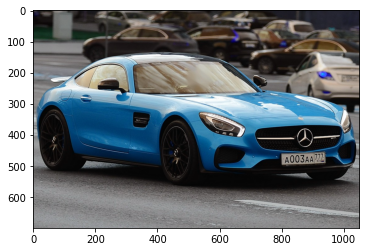

In [ ]:
image = cv.imread('/content/drive/My Drive/Pictures/car_photo.jpg')
plt.imshow(image)

In [ ]:
# activation of selective search
ss = cv.ximgproc.segmentation.createSelectiveSearchSegmentation()

# set up
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()

# making bboxes
rects = ss.process()
print('Total Number of Region Proposals: {}'.format(len(rects)))

Total Number of Region Proposals: 6168


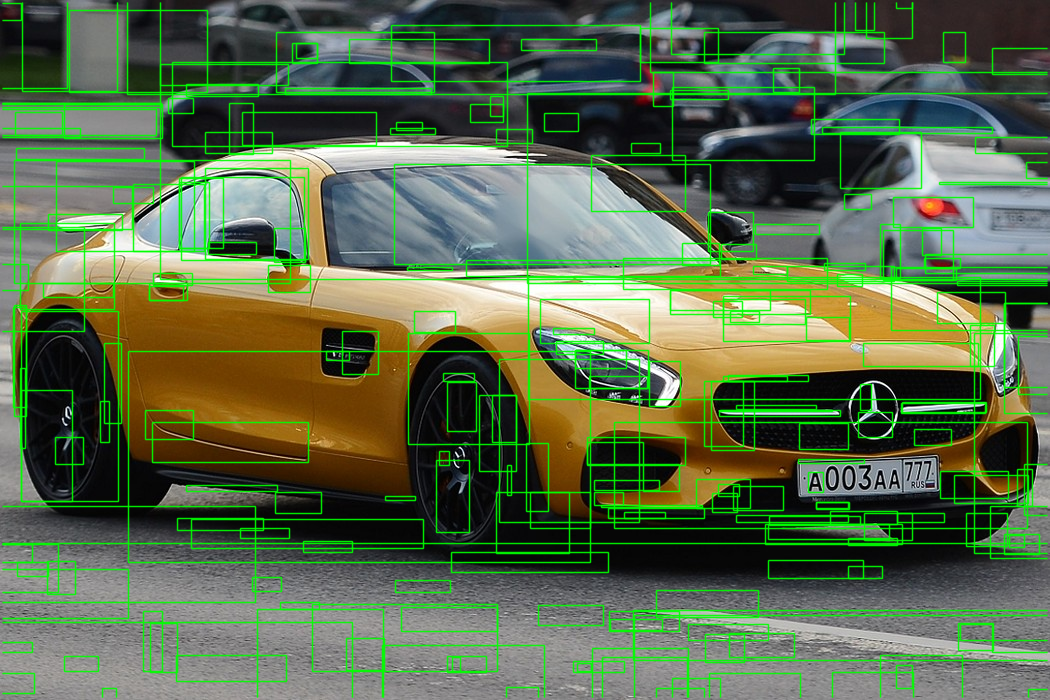

In [ ]:
# create a copy of original image to combinate it with bboxes
img_out = image.copy()

# set the number of boxes we want to draw
num_show_rects = 250

# itereate over all the region proposals
for i, rect in enumerate(rects):
# draw rectangle for region on the image
  if (i < num_show_rects):
    x, y, w, h = rect
    cv.rectangle(img_out, (x, y), (x+w, y+h), (0, 255, 0), 1, cv.LINE_AA)
  else:
    break

# show output
cv2_imshow(img_out)

In [ ]:
# load the model needed to detect the license plate
model_detector = tf.keras.models.load_model('/content/drive/My Drive/Models/micro_detector.hdf5')
print(model_detector.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 130, 320, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 320, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 160, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 65, 160, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 160, 32)       25632     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 160, 32)       25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 80, 32)        0

In [ ]:
check_list = []

# slice images for each bbox
for i in range(len(rects)):
  x, y, w, h = rects[i]
  crop_img = image[y:y+h, x:x+w]
  
  #resize to input model size
  crop_img = cv.resize(crop_img, (320, 130))

  check_list.append(crop_img)

# and finally make an np.array
check_list = np.array(check_list)
check_list.shape

(6168, 130, 320, 3)

In [ ]:
# use the model to determine the probability of finding a license plate in each of the bboxes
# so far the method takes a long time

answers = model_detector.predict(check_list)

# the output matrix consists of two columns, 
# the first is the probability that it is not a license plate
# the second is the probability that it is a license plate

answers

array([[0.17485975, 0.8251403 ],
       [0.99788564, 0.00211437],
       [0.99200684, 0.0079932 ],
       ...,
       [0.98857224, 0.01142778],
       [0.94938445, 0.05061553],
       [0.9978872 , 0.00211276]], dtype=float32)

In [ ]:
max_percentage = answers[:,1].max()
if max_percentage > 0.95:
  index_of_right_bbox = answers[:,1].argmax()

In [ ]:
index_of_right_bbox

4794

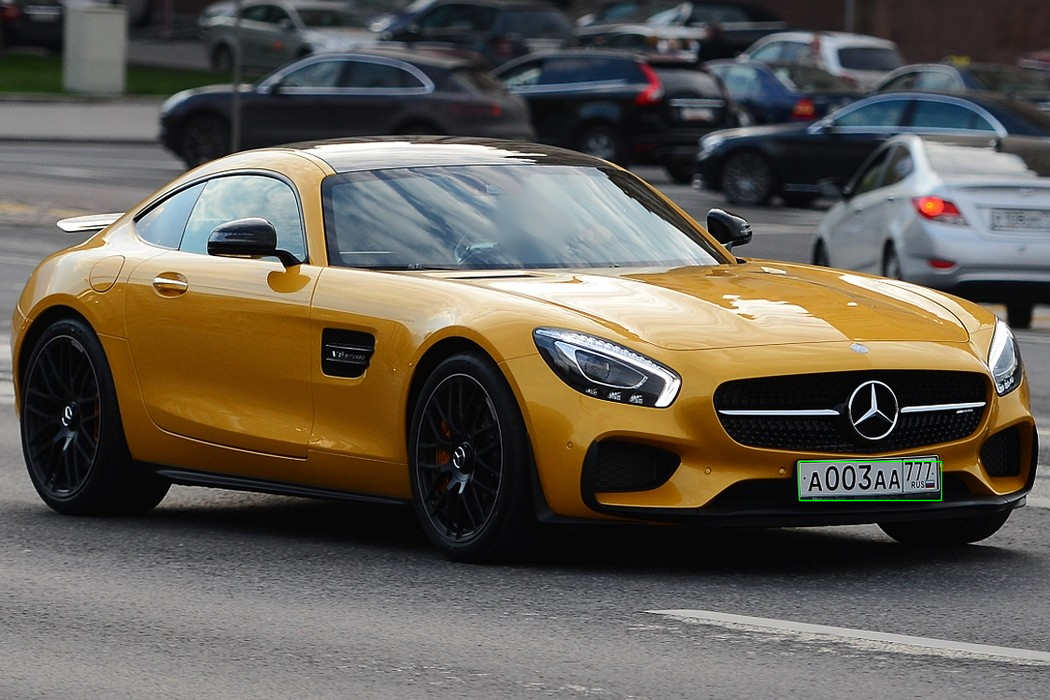

In [ ]:
# or visualize bbox on the car picture
img_out = image.copy()

x, y, w, h = rects[index_of_right_bbox]
cv.rectangle(img_out, (x, y), (x+w, y+h), (0, 255, 0), 1, cv.LINE_AA)

cv2_imshow(img_out)

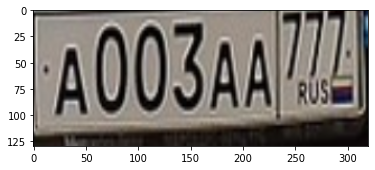

In [ ]:
# we can show our license plate
plt.imshow(check_list[index_of_right_bbox])

In [ ]:
# load the model needed to classify symbols
model_symbols = tf.keras.models.load_model('/content/drive/My Drive/Models/syms_recognitor.hdf5')
print(model_symbols.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 40, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 40, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 20, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 20, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 20, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 10, 64)        0

In [ ]:
max_image = check_list[index_of_right_bbox].copy()

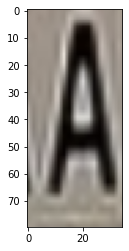

In [ ]:
# a method for detecting each character has not yet been made
# so I cut the picture by hand

x0 = max_image[30:110, 15:60]
x1 = max_image[10:110, 55:95]
x2 = max_image[10:110, 90:135]
x3 = max_image[10:110, 130:170] 
x4 = max_image[25:105, 165:200]
x5 = max_image[25:105, 195:230]

plt.imshow(x5)

In [ ]:
# bring to the form of model input data
syms = [x1,x2,x3,x4,x5,x6]

number = []
for sym in syms: 
  symbol = cv.resize(sym, (40, 50))
  number.append(symbol)

number = np.array(number)
number.shape

(6, 50, 40, 3)

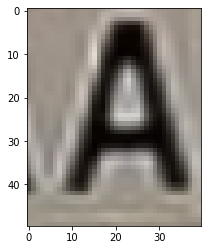

In [ ]:
plt.imshow(number[5])

In [ ]:
for i, sym in enumerate(result):
  # at the places of letters, we choose the maximum probability only among letters
  if i in [0,4,5]:
    sym = sym[10:]
    print(sym.argmax()+10)
    
  # at the places of numbers, we choose the maximum probability only among numbers
  if i in [1,2,3]:
    sym = sym[:9]
    print(sym.argmax())

10
0
0
3
10
10


In [ ]:
# let's make a dictionary, for a nice output
syms_dict = dict([(0, ['0','O']), #because the model cannot distinguish zero from 'O'
                  (1, '1'),
                  (2, '2'),
                  (3, '3'),
                  (4, '4'),
                  (5, '5'),
                  (6, '6'),
                  (7, '7'),
                  (8, '8'),
                  (9, '9'),
                  (10, 'A'),
                  (11, 'B'),
                  (12, 'C'),
                  (13, 'E'),
                  (14, 'H'),
                  (15, 'K'),
                  (16, 'M'),
                  (17, '1'),
                  (18, 'P'),
                  (19, 'T'),
                  (20, 'X'),
                  (21, 'Y')
                  ])

In [ ]:
# and upgrade algorithm a little bit

plate_str = ''

for i, sym in enumerate(result):
  # at the places of letters, we choose the maximum probability only among letters
  if i in [0,4,5]:
    sym = sym[10:]
    res = sym.argmax()+10

    # to account for the difference between zero and 'O'
    if res == 0:
      plate_str += syms_dict[res][1]
    else:
      plate_str += syms_dict[res]

  # at the places of numbers, we choose the maximum probability only among numbers
  if i in [1,2,3]:
    sym = sym[:9]
    res = sym.argmax()

    # to account for the difference between zero and 'O'
    if res == 0:
      plate_str += syms_dict[res][0]
    else:
      plate_str += syms_dict[res]

print(plate_str)

A003AA
